## Introduction

In this notebook we're going to build and train a deep learning model "from scratch" -- by which I mean that we're not going to use any pre-built architecture, or optimizers, or data loading frameworks, etc.

We'll be assuming you already know the basics of how a neural network works. If you don't, read this notebook first: [How does a neural net really work?
](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work). We'll be using Kaggle's [Titanic](https://www.kaggle.com/competitions/titanic/) competition in this notebook, because it's very small and simple, but also has displays many of the tricky real-life issues that we need to handle in most practical projects. (Note, however, that this competition is a small "learner" competition on Kaggle, so don't expect to actually see much benefits from using a neural net just yet; that will come once we try our some real competitions!)

It's great to be able to run the same notebook on your own machine or Colab, as well as Kaggle. To allow for this, we use this code to download the data as needed when not on Kaggle (see [this notebook](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners/) for details about this technique):

In [ ]:
import os
from pathlib import Path
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)
!rm titanic.zip

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34.1k/34.1k [00:00<00:00, 1.41MB/s]

Note that the data for Kaggle comps always lives in the `../input` folder. The easiest way to get the path is to click the "K" button in the top-right of the Kaggle notebook, click on the folder shown there, and click the copy button.

We'll be using *numpy* and *pytorch* for array calculations in this notebook, and *pandas* for working with tabular data, so we'll import them and set them to display using a bit more space than they default to.

In [ ]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Cleaning the data

Reading in the data with pandas

In [ ]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Checking if our data has any missing values

In [ ]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

As we can see some of `age` and `Cabin` values are missing, we will handle that with filling them in with the `mode` of the value

In [ ]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

He are the modes for every value \
and we fill in the missing values

In [ ]:
df.fillna(modes, inplace=True)

In [ ]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Here we can see how our numerical values are distributed with `describe()` method, `include` parameters ensures we only see numeric values

In [ ]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


From the `describe` we can see that `Fare` has `max` value of 512 while the `min` value is 0 and 75% of the Fare's are below 31 lets see Fare distribution on the histogram.

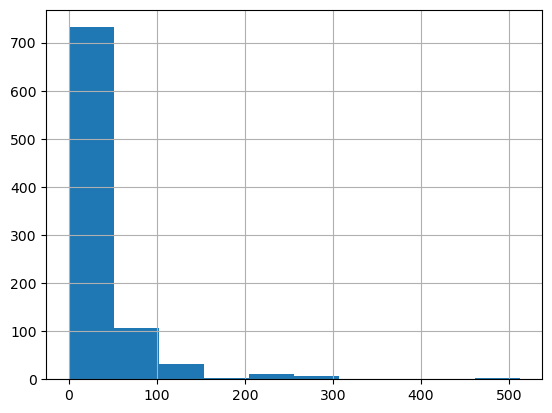

In [ ]:
df['Fare'].hist();

As w can see most of our values are low numbers with some values a lot higher, it is actually common distribution in monetary values. One way to deal with this problem is to take a log of values. \
We will actually take a log(a+1) since log of number lower than 1 is negative number, and we want our numbers to all be non negative

In [ ]:
df['LogFare'] = np.log(df['Fare']+1)

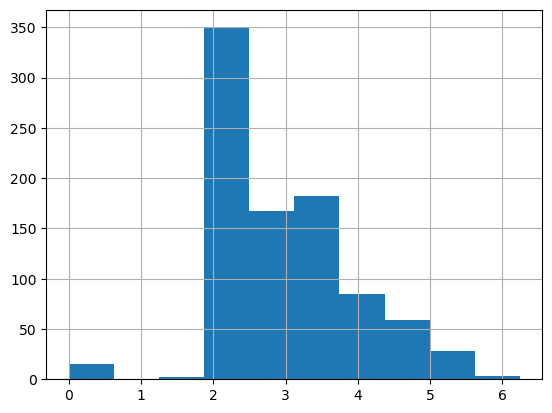

In [ ]:
df['LogFare'].hist();

Our distribution look a lot better.

It looks like from the `describe()` output, the Pclass has only `3` values, which we can confirm by looking at `Pclass.unique()`

In [ ]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

Here's how we get a quick summary of all the non-numeric columns in the dataset:

In [ ]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


Since we can't multiply strings like `Sex` `male` by a parameter, we need to replace them with numbers. \
With `Sex` column it is pretty simple, just replace male with `1` and female with `0`. \
For the other values we will create additional column saying for example `is` this Embarked: `S` if yes just set value to `1` else `0`

Pandas can create these automatically with `get_dummies` method, which also removes original columns. We'll create dummy variables for `Pclass`, even although it's numeric, since the numbers 1, 2, and 3 correspond to first, second, and third class cabins - not to counts or measures that make sense to multiply by. We'll also create dummies for `Sex` and `Embarked` since we'll want to use those as predictors in our model. On the other hand, Cabin, Name, and Ticket have too many unique values for it to make sense creating dummy variables for them.

In [ ]:
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

Here is what the added columns look like

In [ ]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


Here we create our independent(predictor)and the dependent(target) the value we want our model to predict. We want both of them to be `tensors`.

In [ ]:
from torch import tensor

t_dep = tensor(df.Survived)

In [ ]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

Here is the number of rows and columns we have.

In [ ]:
t_indep.shape

torch.Size([891, 12])

## Setting up a linear model

Now that we've got a matrix of independent and dependent values, we can work on calculating our predictions and our loss.

Our first model will be a simple linear model. We'll need a `coefficient`(Parameter) for each column in `t_indep`. We'll assign it a random number between -0.5 and 0.5.

In [ ]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

We created our coeffs [12,1] tensor. \
Here is what the multiplication looks like.

In [ ]:
t_indep*coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

In [ ]:
t_indep.max(dim =0)

torch.return_types.max(
values=tensor([80.0000,  8.0000,  6.0000,  6.2409,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000]),
indices=tensor([630, 159, 678, 258,   0,   1,   1,   9,   0,   1,   5,   0]))

We see we've got a problem here. The sum of  each row will be dominated by the `Age` column, since it's bigger on the average.

Let's make all the columns contain numbers from `0` to `1`, by dividing each column by its `max()`:

In [ ]:
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals

In [ ]:
t_indep*coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

Now it look a lot better. \
Now we can make prediction from our linear model, by adding up the rows of the product

NOTE for axis 
* if 0 - > return sum of columns 
* if 1 - > return sum of the rows

In [ ]:
preds = (t_indep*coeffs).sum(axis=1)

Let's take a look at the first few:

In [ ]:
preds[:10]

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

Of course, those predictions aren't good since our coefficient were random. To do the gradient descent, we need a loss function.

In [ ]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5382)

Now that we've tested out a way of calculating predictions, and loss, let's pop them into functions to make life easier:

In [ ]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

# Doing the gradient descent step

In this section, we will try to improve our coefficient by calculating the gradients and updating our coeffs. \
To get pytorch to calculate the gradients, we need to call `required_grad_()` on our `coeffs`.

In [ ]:
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

Now we need to calculate our loss.

In [ ]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

Use `backward()` to ask PyTorch to calculate gradients now:

In [ ]:
loss.backward()

Let's see what they look like:

In [ ]:
coeffs.grad

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

Now each time we will call `bakwards()`. The gradients are actually added to whatever is in the .grad attribute. Let's try running the above steps again.

In [ ]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.0212,  0.0258, -0.0082, -0.0969,  0.4198, -0.4265, -0.2424, -0.0494,  0.2851, -0.3771, -0.0382,  0.4085])

As we can see our `.grad` values have doubled. That's because it added the gradients a second time. \
For this reason, after we use the gradients to do a gradient descent step, we need to set them back to zero.

We can do one gradient descent step, and check that our loss decreases.

In [ ]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad(): # We use .no_grad() here since w don't want gradients of .sub_
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.4945)


Note that `abc.sub_(b)` subtracts `b` from the `a` in-place. In PyTorch, any method that ends with `_` changes the object in place. Similar `abc.zero()` sets all the elements of tensor to zero.

## Training the linear model

Let's import RandomSplitter from fastai and split our data into training and validation set

In [ ]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

Now we can apply those indicies to our independent and dependent variables:

In [ ]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

Lest's create a function to make things easier

In [ ]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [ ]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

Reminder this function will initialize coeffs

In [ ]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

We can now use these functions to train our model:

In [ ]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

Let's train our model for 18 epochs with lr = 0.2

In [ ]:
coeffs = train_model(18, lr=0.2)

0.536; 0.502; 0.477; 0.454; 0.431; 0.409; 0.388; 0.367; 0.349; 0.336; 0.330; 0.326; 0.329; 0.304; 0.314; 0.296; 0.300; 0.289; 

It does!

Let's take a look at the coefficients for each column:

In [ ]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2694),
 'SibSp': tensor(0.0901),
 'Parch': tensor(0.2359),
 'LogFare': tensor(0.0280),
 'Sex_male': tensor(-0.3990),
 'Sex_female': tensor(0.2345),
 'Pclass_1': tensor(0.7232),
 'Pclass_2': tensor(0.4112),
 'Pclass_3': tensor(0.3601),
 'Embarked_C': tensor(0.0955),
 'Embarked_Q': tensor(0.2395),
 'Embarked_S': tensor(0.2122)}

## Measuring accuracy

The Kaggle competition is not, however, scored by absolute error (which is our loss function). It's scored by *accuracy* -- the proportion of rows where we correctly predict survival. Let's see how accurate we were on the validation set. First, calculate the predictions:

In [ ]:
preds = calc_preds(coeffs, val_indep)

We'll assume that any passenger with a score of over `0.5` is predicted to survive. So that means we're correct for each row where `preds>0.5` is the same as the dependent variable:

In [ ]:
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

Let's see what our average accuracy is:

In [ ]:
results.float().mean()

tensor(0.7865)

That's not a bad start at all! We'll create a function so we can calcuate the accuracy easy for other models we train:

In [ ]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7865)

## Using sigmoid

Looking at our predictions,we can see that some of the values are `>1` and some of them are `<0` 

In [ ]:
preds[:28]

tensor([ 0.8160,  0.1295, -0.0148,  0.1831,  0.1520,  0.1350,  0.7279,  0.7754,  0.3222,  0.6740,  0.0753,  0.0389,  0.2216,  0.7631,
         0.0678,  0.3997,  0.3324,  0.8278,  0.1078,  0.7126,  0.1023,  0.3627,  0.9937,  0.8050,  0.1153,  0.1455,  0.8652,  0.3425])

To fix this we can put our prediction into sigmoid function, which has minimum of 0 and maximum of 1. \
Here is what is looks like

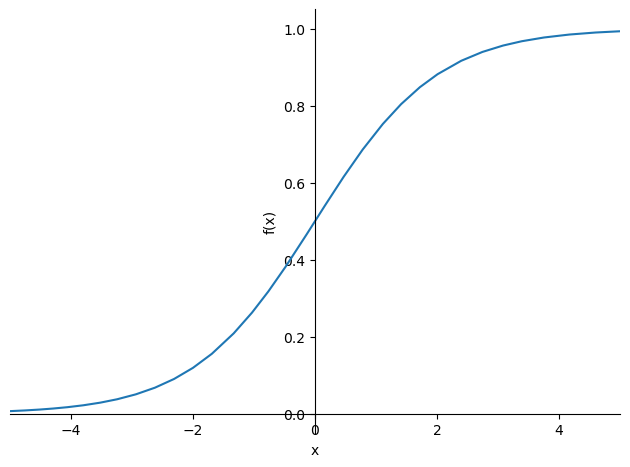

In [ ]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

Pytorch already defines that function for us, so we just need to modify the function

In [ ]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [ ]:
coeffs = train_model(lr=100)

0.510; 0.327; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [ ]:
acc(coeffs)

tensor(0.8258)

The accuracy went up by a lot! Let's the coeffs

In [ ]:
show_coeffs()

{'Age': tensor(-1.5061),
 'SibSp': tensor(-1.1575),
 'Parch': tensor(-0.4267),
 'LogFare': tensor(0.2543),
 'Sex_male': tensor(-10.3320),
 'Sex_female': tensor(8.4185),
 'Pclass_1': tensor(3.8389),
 'Pclass_2': tensor(2.1398),
 'Pclass_3': tensor(-6.2331),
 'Embarked_C': tensor(1.4771),
 'Embarked_Q': tensor(2.1168),
 'Embarked_S': tensor(-4.7958)}

## Submitting to Kaggle

Now that we've got a trained model, we can prepare a submission to Kaggle. To do that, first we need to read the test set:

In [ ]:
tst_df = pd.read_csv(path/'test.csv')

In [ ]:
tst_df['Fare'] = tst_df.Fare.fillna(0)

Now we can just copy the same steps we did to our training set and do the same exact things on our test set to preprocess the data:

In [ ]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])

tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

In [ ]:
tst_df['Survived'] = (calc_preds(tst_indep, coeffs)>0.5).int()

In [ ]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

We can check the first few rows of the file to make sure it looks reasonable:

In [ ]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


When you click "save version" in Kaggle, and wait for the notebook to run, you'll see that `sub.csv` appears in the "Data" tab. Clicking on that file will show a *Submit* button, which allows you to submit to the competition.

## Using matrix product

We can make things quite a bit neater...

Take a look at the inner-most calculation we're doing to get the predictions:

In [ ]:
(val_indep*coeffs).sum(axis=1)

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3512, -13.6469,   3.6248,   5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,
          3.9393, -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237, -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,
         -2.7433, -12.3210, -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,  -3.2275, -12.0289,  13.4560, -21.7230,
         -3.1366, -13.2462, -21.7230, -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,  -2.9386,  -5.3103, -22.2384,
        -22.1097, -21.7466, -13.3780, -13.4909, -14.8119, -22.0690, -21.6666, -21.7818,  -5.4439, -21.7407, -12.6551, -21.6671,   4.9238,
        -11.5777, -13.3323, -21.9638, -15.3030,   5.0243, -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230, -11.9652,
        -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,   4.9207,  -7.3198,  -5.3081,   7.1065,  11.4948, -13.3135, -21.8723,
        -21.7230,  13.3603, -15.56

Multiplying elements together and then adding across rows is identical to doing a matrix-vector product! Python uses the `@` operator to indicate matrix products, and is supported by PyTorch tensors. Therefore, we can replicate the above calculate more simply like so:

In [ ]:
val_indep@coeffs

tensor([ 12.3288, -14.8119, -15.4540, -13.1513, -13.3511, -13.6468,   3.6248,   5.3429, -22.0878,   3.1233, -21.8742, -15.6421, -21.5504,
          3.9393, -21.9190, -12.0010, -12.3775,   5.3550, -13.5880,  -3.1015, -21.7237, -12.2081,  12.9767,   4.7427, -21.6525, -14.9135,
         -2.7433, -12.3210, -21.5886,   3.9387,   5.3890,  -3.6196, -21.6296, -21.8454,  12.2159,  -3.2275, -12.0289,  13.4560, -21.7230,
         -3.1366, -13.2462, -21.7230, -13.6831,  13.3092, -21.6477,  -3.5868, -21.6854, -21.8316, -14.8158,  -2.9386,  -5.3103, -22.2384,
        -22.1097, -21.7466, -13.3780, -13.4909, -14.8119, -22.0690, -21.6666, -21.7818,  -5.4439, -21.7407, -12.6551, -21.6671,   4.9238,
        -11.5777, -13.3323, -21.9638, -15.3030,   5.0243, -21.7614,   3.1820, -13.4721, -21.7170, -11.6066, -21.5737, -21.7230, -11.9652,
        -13.2382, -13.7599, -13.2170,  13.1347, -21.7049, -21.7268,   4.9207,  -7.3198,  -5.3081,   7.1065,  11.4948, -13.3135, -21.8723,
        -21.7230,  13.3603, -15.56

As u can see the output is identical, but using `@` operator makes the matrix multiply much faster.

In [ ]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

In [ ]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

In [ ]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

We can now train our model as before and confirm we get identical outputs...:

In [ ]:
coeffs = train_model(lr=100)

0.512; 0.323; 0.290; 0.205; 0.200; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

...and identical accuracy:

In [ ]:
acc(coeffs)

tensor(0.8258)

## A neural network

We've now got what we need to implement our neural network.

First, we'll need to create coefficients for each of our layers. Our first set of coefficients will take our `n_coeff` inputs, and create `n_hidden` outputs. We can choose whatever `n_hidden` we like -- a higher number gives our network more flexibility, but makes it slower and harder to train. So we need a matrix of size `n_coeff` by `n_hidden`. We'll divide these coefficients by `n_hidden` so that when we sum them up in the next layer we'll end up with similar magnitude numbers to what we started with.

Then our second layer will need to take the `n_hidden` inputs and create a single output, so that means we need a `n_hidden` by `1` matrix there. The second layer will also need a constant term added.

In [ ]:
n_hidden = 20
(torch.rand(n_coeff, n_hidden)) # n_coeffs - number of rows, n_hidden - number of coeffs in a row
torch.rand(n_hidden,1) # 

tensor([0.7839, 0.4441, 0.7304, 0.4664, 0.4205, 0.9709, 0.0276, 0.5295, 0.7127, 0.7399, 0.9193, 0.9949, 0.9180, 0.6263, 0.3220, 0.2740,
        0.9050, 0.5448, 0.1600, 0.1784])

In [ ]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

Now we have our coefficients, we can create our neural net. The key steps are the two matrix products, `indeps@l1` and `res@l2` (where `res` is the output of the first layer). The first layer output is passed to `F.relu` (that's our non-linearity), and the second is passed to `torch.sigmoid` as before.

In [ ]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

Finally, now that we have more than one set of coefficients, we need to add a loop to update each one:

In [ ]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

That's it -- we're now ready to train our model!

In [ ]:
coeffs = train_model(lr=1.4)
acc(coeffs)

0.543; 0.532; 0.520; 0.505; 0.487; 0.466; 0.439; 0.407; 0.373; 0.343; 0.319; 0.301; 0.286; 0.274; 0.264; 0.256; 0.250; 0.245; 0.240; 0.237; 0.234; 0.231; 0.229; 0.227; 0.226; 0.224; 0.223; 0.222; 0.221; 0.220; 

tensor(0.7921)

In [ ]:
coeffs = train_model(lr=20)
acc(coeffs)

0.543; 0.400; 0.260; 0.390; 0.221; 0.211; 0.197; 0.195; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.193; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 0.192; 

tensor(0.8258)

It's looking good

In this case our neural net isn't showing better results than the linear model. That's not surprising; this dataset is very small and very simple, and isn't the kind of thing we'd expect to see neural networks excel at. Furthermore, our validation set is too small to reliably see much accuracy difference. But the key thing is that we now know exactly what a real neural net looks like!

## Deep learning

The neural net in the previous section only uses one hidden layer, so it doesn't count as "deep" learning. But we can use the exact same technique to make our neural net deep, by adding more matrix multiplications.

First, we'll need to create additional coefficients for each layer:

Understanding `init_coeffs`

In [ ]:
sizes = [12] + [10,10] + [1]
sizes

[12, 10, 10, 1]

In [ ]:
n = len(sizes)
ly = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
ly

[tensor([[-0.0885, -0.0638,  0.0772, -0.0345,  0.0909,  0.1749,  0.0677,  0.0966,  0.1951,  0.2063],
         [-0.0830,  0.1576,  0.0236, -0.0339, -0.0435,  0.1856,  0.0527, -0.0925,  0.2777,  0.2286],
         [ 0.2143,  0.2019, -0.1154, -0.1139,  0.1705,  0.1669,  0.0929,  0.0492,  0.0093,  0.0219],
         [ 0.2064,  0.0697,  0.1346,  0.0099,  0.0619,  0.1576,  0.1706,  0.2313,  0.1813,  0.1084],
         [-0.0234,  0.1411,  0.1117,  0.2572,  0.1412,  0.0425, -0.0518,  0.2002,  0.2679,  0.1291],
         [ 0.0778, -0.0274, -0.0914,  0.0320,  0.0827,  0.2084, -0.0432, -0.0596, -0.1159,  0.1561],
         [-0.0663,  0.0115, -0.0512, -0.0736,  0.1799, -0.1023,  0.2382,  0.1505, -0.1048, -0.1080],
         [ 0.0528,  0.1592,  0.1679,  0.1505,  0.2484, -0.0191, -0.0484,  0.1934,  0.1189,  0.0669],
         [ 0.1171,  0.2428,  0.2765, -0.1061,  0.1507,  0.1123,  0.0138,  0.2528, -0.0910,  0.2024],
         [-0.0933,  0.2470,  0.0178, -0.0918,  0.0222, -0.0396,  0.1512,  0.2310,  0.0195, 

In [ ]:
con = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
con

[tensor(0.0139), tensor(-0.0015), tensor(-0.0319)]

In [ ]:
for i in ly + con:
    print(i)

tensor([[-0.0885, -0.0638,  0.0772, -0.0345,  0.0909,  0.1749,  0.0677,  0.0966,  0.1951,  0.2063],
        [-0.0830,  0.1576,  0.0236, -0.0339, -0.0435,  0.1856,  0.0527, -0.0925,  0.2777,  0.2286],
        [ 0.2143,  0.2019, -0.1154, -0.1139,  0.1705,  0.1669,  0.0929,  0.0492,  0.0093,  0.0219],
        [ 0.2064,  0.0697,  0.1346,  0.0099,  0.0619,  0.1576,  0.1706,  0.2313,  0.1813,  0.1084],
        [-0.0234,  0.1411,  0.1117,  0.2572,  0.1412,  0.0425, -0.0518,  0.2002,  0.2679,  0.1291],
        [ 0.0778, -0.0274, -0.0914,  0.0320,  0.0827,  0.2084, -0.0432, -0.0596, -0.1159,  0.1561],
        [-0.0663,  0.0115, -0.0512, -0.0736,  0.1799, -0.1023,  0.2382,  0.1505, -0.1048, -0.1080],
        [ 0.0528,  0.1592,  0.1679,  0.1505,  0.2484, -0.0191, -0.0484,  0.1934,  0.1189,  0.0669],
        [ 0.1171,  0.2428,  0.2765, -0.1061,  0.1507,  0.1123,  0.0138,  0.2528, -0.0910,  0.2024],
        [-0.0933,  0.2470,  0.0178, -0.0918,  0.0222, -0.0396,  0.1512,  0.2310,  0.0195,  0.1205],


In [ ]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    # Creates n-1 number of layers
    # First layer [n_coeffs,hidden] second layer [hidden,hidden], third [hidden,1]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    # Create (n-1) number of constants for each layer
    for l in layers+consts: l.requires_grad_()
    # adds requires grad to each layer and const 
    return layers,consts

You'll notice here that there's a lot of messy constants to get the random numbers in just the right ranges. When you train the model in a moment, you'll see that the tiniest changes to these initialisations can cause our model to fail to train at all! This is a key reason that deep learning failed to make much progress in the early days -- it's very finicky to get a good starting point for our coefficients. Nowadays, we have ways to deal with that, which we'll learn about in other notebooks.

Our deep learning `calc_preds` looks much the same as before, but now we loop through each layer, instead of listing them separately:

In [ ]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        # This does the same thing neural network does
        # res * l_n + consts
        # loops -> n+1
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res) # Updates res
    return torch.sigmoid(res)

We also need a minor update to `update_coeffs` since we've got `layers` and `consts` separated now:

Old ones for the comparason
```Python
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()
```


In [ ]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

Let's train our model...

In [ ]:
coeffs = train_model(lr=4)

0.521; 0.483; 0.427; 0.379; 0.379; 0.379; 0.379; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.377; 0.376; 0.371; 0.333; 0.239; 0.224; 0.208; 0.204; 0.203; 0.203; 0.207; 0.197; 0.196; 0.195; 

...and check its accuracy:

In [ ]:
acc(coeffs)

tensor(0.8258)

## Final thoughts

It's actually pretty cool that we've managed to create a real deep learning model from scratch and trained it to get over 80% accuracy on this task, all in the course of a single notebook!

The "real" deep learning models that are used in research and industry look very similar to this, and in fact if you look inside the source code of any deep learning model you'll recognise the basic steps are the same.

The biggest differences in practical models to what we have above are:

- How initialisation and normalisation is done to ensure the model trains correctly every time
- Regularization (to avoid over-fitting)
- Modifying the neural net itself to take advantage of knowledge of the problem domain
- Doing gradient descent steps on smaller batches, rather than the whole dataset.

I'll be adding notebooks about all these later, and will add links here once they're ready.

If you found this notebook useful, please remember to click the little up-arrow at the top to upvote it, since I like to know when people have found my work useful, and it helps others find it too. (BTW, be sure you're looking at my [original notebook here](https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch) when you do that, and are not on your own copy of it, otherwise your upvote won't get counted!) And if you have any questions or comments, please pop them below -- I read every comment I receive!

In [ ]:
#|hide
!rm -r titanic
!rm sub.csv